In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from Levenshtein import distance as edit_distance
import pandas as pd
import seaborn as sns



In [2]:
'''
Computes the id_estimate using all the dataset points for local estimates
and then we average across all the estimates ...
distances: distance of each anchor to their k nearest neighbors
dataset_size: number of anchor_points from dataset to be used for the estimation
unbiased_estimation: whether or not to make the MLE estimator asymptotically unbiased
'''
def id_estimator(k_value, dataset_size, distances, unbiased_estimation):
    # print(dataset.shape[0] == distances.shape[0])
    estimates = []
    for i in range(dataset_size):
        ### access the distances for each anchor...
        k_distances = np.array(distances[i])

        ### check if any distances are 0, if so naively just ignore this local estimate because it should've already been accounted for
        if np.all(k_distances[1:-1]) == False:
            continue

        ### ignore the 1st closest neighbor, duplicate the last (kth neighbor) and div
        k_distances_normalized = np.array((k_value - 1)*[k_distances[-1]])/k_distances[1:-1] # Tk(x)/Tj(x)

        # apply the log function ...
        k_distances_normalized_log = np.log(k_distances_normalized) # take log of k_value - 1 values

        '''
        In original paper by Levina and Bickel
        Note that we omit the last (zero) term in the sum in (7). One could divide by
        k − 2 rather than k − 1 to make the estimator asymptotically unbiased, as we show
        below. Also note that the MLE of θ can be used to obtain an instant estimate of
        the entropy of f, which was also provided by the method used in [15].
        '''
        # average the inverse of the estimators ...
        # we divide by k_value - 2 instead to make the MLE estimator asymptotically unbiased
        if unbiased_estimation: 
            k_distance_id_estimate = (1/(k_value - 2)) * np.sum(k_distances_normalized_log, axis=-1)
        else: # biased regards the kth value in the averaging, hence the k + 1
            k_distance_id_estimate = (1/(k_value - 1)) * np.sum(k_distances_normalized_log, axis=-1)

        ### store into the estimates array
        estimates.append(k_distance_id_estimate) 

    ### Average the estimates together and return
    estimates_avg_id = (1/dataset_size) * np.sum( np.array(estimates) )
    id_estimated = 1/estimates_avg_id

    # return the final estimated id value...
    return id_estimated

'''
The function below returns the intrinsic dimensionality estimation
across different values of k (kNN) using MLE estimation ...
dataset: combines train and test datasets MNIST, CIFAR-*, etc.
'''
def id_mle_estimator(dataset, k_list=[2,3,5,10,20], unbiased_estimation=False):
    # Create a map of key (k in kNN) to values (estimates using different anchor points)
    id_estimates = { val:[] for val in k_list }
    dataset_size = dataset.shape[0] # get the size of the dataset...

    # perform the classification and computation only once for maximum k
    classifier = NearestNeighbors(n_neighbors=max(k_list)+1, algorithm='ball_tree') #ball_tree, brute, kd_tree
    classifier.fit(dataset)

    # We use the entire dataset to find good local estimates (for maximum K value) 
    # [assumes data exists in local neighborhoods] (locally uniform distribution)
    distances, indices = classifier.kneighbors(dataset)

    # For each k val from 1 <-> num_k, pass the distances up to that k+1
    for k in k_list:
      # calling scheme: k_id_mle_estimator(k, dataset, anchor_points, anchors_sampling_count, testing=False)
        id_estimates[k] = id_estimator(k, dataset_size, distances[:, :k+1], unbiased_estimation)

    # return the object containing the estimates...
    return id_estimates

In [3]:
n = 4000
d = 8
D = 128
means = 0.5 + 0.09*np.random.randn(d)
Cov = 0.01*np.eye(d)
data_low = np.random.multivariate_normal(means, Cov, size=n)
L = (np.random.randn(d, D)+1)/d
data_high = data_low @ L


In [4]:
data_high.shape

(4000, 128)

In [5]:
results_unbiased = id_mle_estimator(data_high, k_list=list(range(3,30)), unbiased_estimation=True) # (used by Philip et. al.)

Text(0.5,1,'Unbiased local ID estimation')

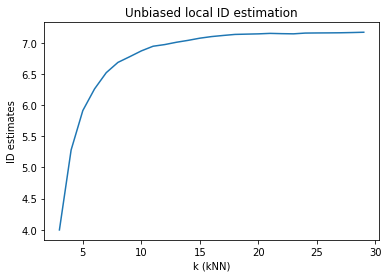

In [6]:
x_domain = list(results_unbiased.keys())
plt.plot(x_domain, list(results_unbiased.values()))
plt.xlabel("k (kNN)")
plt.ylabel("ID estimates")
plt.title("Unbiased local ID estimation")
# plt.legend(framealpha=1, frameon=True)

In [3]:
def generate_query(means, Cov, L):
    return np.random.multivariate_normal(means, Cov, size=1) @ L

def distance_permutation(q, anchs):
    return np.argsort([np.linalg.norm(q-a) for a in anchs])

In [18]:
piv = [6,7,8,12,16]

query = generate_query(means, Cov, L)
sort_idx = np.argsort([np.linalg.norm(u-query) for u in data_high])
k = 200
found = np.zeros((len(piv), n))
for j, num_pivots in enumerate(piv):
    anchor_idx = np.random.choice(n, size=num_pivots)
    anchors = np.array([data_high[i] for i in anchor_idx])
    perms = np.zeros((n, num_pivots))
    for i in range(n):
        perms[i] = np.argsort([np.linalg.norm(data_high[i]-a) for a in anchors])

    dperm = distance_permutation(query, anchors)
    sort_perm_idx = np.argsort([np.linalg.norm(np.argsort(p)-np.argsort(dperm)) for p in perms])
    
    for c, idx in enumerate(sort_perm_idx):
        if idx in sort_idx[:k]:
            found[j,c] = found[j,c-1] + 1
        else:
            found[j,c] = found[j,c-1]

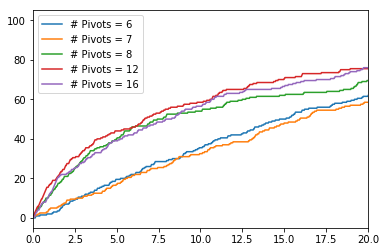

In [19]:
for i in range(found.shape[0]):
    plt.plot(100*np.arange(n)/n, found[i]/k*100, label='# Pivots = %s' % piv[i])

plt.xlim([0, 20])
plt.legend()

In [20]:
found[:,200]

array([39., 34., 80., 88., 78.])

In [60]:
trials = 20
n = 4000
d = 32
D = 512
means = 0.5 + 0.09*np.random.randn(d)
Cov = 0.01*np.eye(d)
data_low = np.random.multivariate_normal(means, Cov, size=n)
L = (np.random.randn(d, D)+1)/d
data_high = data_low @ L # shape = (n, D)

queries = np.array([generate_query(means, Cov, L) for _ in range(trials)]) # shape = (trials, D)
sort_idxs = np.array([np.argsort([np.linalg.norm(u-query) for u in data_high]) for query in queries]) # shape = (trials, n)

pivots = [8,16,32,48,64]
k = 40
all_found0 = np.zeros((trials, len(pivots), n))
for t in range(trials):
    query = queries[t]
    found = np.zeros((len(piv), n))
    sort_idx = sort_idxs[t]
    for j, num_pivots in enumerate(pivots):
        anchor_idx = np.random.choice(n, size=num_pivots)
        anchors = np.array([data_high[i] for i in anchor_idx])
        perms = np.zeros((n, num_pivots))
        for i in range(n):
            perms[i] = np.argsort([np.linalg.norm(data_high[i]-a) for a in anchors])

        dperm = distance_permutation(query, anchors)
        sort_perm_idx = np.argsort([np.linalg.norm(np.argsort(p)-np.argsort(dperm)) for p in perms])

        for c, idx in enumerate(sort_perm_idx):
            if idx in sort_idx[:k]:
                all_found0[t,j,c] = all_found0[t,j,c-1] + 1
            else:
                all_found0[t,j,c] = all_found0[t,j,c-1]



[ 7.875 13.625 20.625 26.875 30.875]


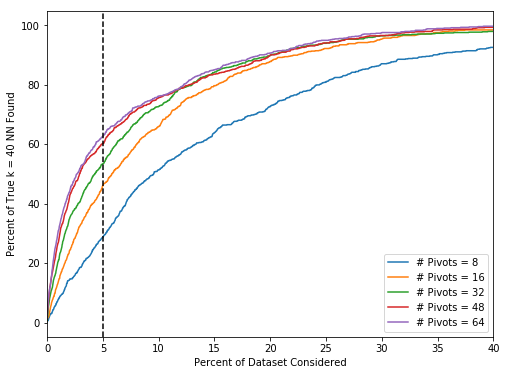

In [61]:
plt.figure(figsize=(8,6))

f2 = all_found0.mean(axis=0)
for i in range(f2.shape[0]):
    plt.plot(100*np.arange(n)/n, f2[i]/k*100, label='# Pivots = %s' % pivots[i])

plt.axvline(5, linestyle='--', color='k')
plt.xlim([0, 40])
plt.xlabel('Percent of Dataset Considered')
plt.ylabel('Percent of True k = 40 NN Found')
plt.legend()

print(f2[:,k]/k * 100)

In [62]:
trials = 20
n = 4000
d = 32
D = 512
means = 0.5 + 0.09*np.random.randn(d)
Cov = 0.01*np.eye(d)
data_low = np.random.multivariate_normal(means, Cov, size=n)
L = (np.random.randn(d, D)+1)/d
data_high = data_low @ L # shape = (n, D)

queries = np.array([generate_query(means, Cov, L) for _ in range(trials)]) # shape = (trials, D)
sort_idxs = np.array([np.argsort([np.linalg.norm(u-query) for u in data_high]) for query in queries]) # shape = (trials, n)

pivots = [8,16,32,48,64]
k = 40
all_found1 = np.zeros((trials, len(pivots), n))
all_found2 = np.zeros((trials, len(pivots), n))
for t in range(trials):
    query = queries[t]
    found = np.zeros((len(piv), n))
    sort_idx = sort_idxs[t]
    for j, num_pivots in enumerate(pivots):
        anchor_idx = np.random.choice(n, size=num_pivots)
        anchors = np.array([data_high[i] for i in anchor_idx])
        perms1 = np.zeros((n, num_pivots))
        perms2 = n*['0']
        for i in range(n):
            perm = np.argsort([np.linalg.norm(data_high[i]-a) for a in anchors])
            perms1[i] = perm
            perms2[i] = ''.join([chr(c) for c in perm])

        dperm = distance_permutation(query, anchors)
        dperm_str = ''.join([chr(c) for c in dperm])
        sort_perm_idx1 = np.argsort([np.linalg.norm(np.argsort(p)-np.argsort(dperm)) for p in perms1])
        sort_perm_idx2 = np.argsort([edit_distance(dperm_str, p) for p in perms2])

        for c, idx in enumerate(zip(sort_perm_idx1, sort_perm_idx2)):
            idx1, idx2 = idx
            if idx1 in sort_idx[:k]:
                all_found1[t,j,c] = all_found1[t,j,c-1] + 1
            else:
                all_found1[t,j,c] = all_found1[t,j,c-1]
            if idx2 in sort_idx[:k]:
                all_found2[t,j,c] = all_found2[t,j,c-1] + 1
            else:
                all_found2[t,j,c] = all_found2[t,j,c-1]



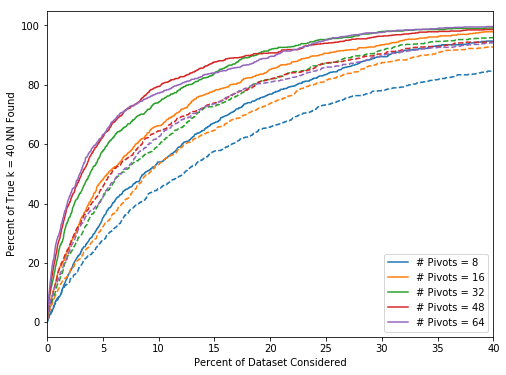

In [64]:
plt.figure(figsize=(8,6))

F1 = all_found1.mean(axis=0)
for i in range(f2.shape[0]):
    plt.plot(100*np.arange(n)/n, F1[i]/k*100, label='# Pivots = %s' % pivots[i])

plt.gca().set_prop_cycle(None)
F2 = all_found2.mean(axis=0)
for i in range(f2.shape[0]):
    plt.plot(100*np.arange(n)/n, F2[i]/k*100, '--')

# plt.axvline(5, linestyle='--', color='k')
plt.xlim([0, 40])
plt.xlabel('Percent of Dataset Considered')
plt.ylabel('Percent of True k = 40 NN Found')
plt.legend()

In [65]:
print(F1[:,k]/k * 100)
print(F2[:,k]/k * 100)

[ 8.25 17.   23.   26.75 29.  ]
[ 8.    11.125 13.25  17.25  14.375]


In [15]:
trials = 20
n = 4000
d = 8
D = 128
means = 0.5 + 0.09*np.random.randn(d)
Cov = 0.01*np.eye(d)
data_low = np.random.multivariate_normal(means, Cov, size=n)
L = (np.random.randn(d, D)+1)/d
data_high = data_low @ L # shape = (n, D)

queries = np.array([generate_query(means, Cov, L) for _ in range(trials)]) # shape = (trials, D)
sort_idxs = np.array([np.argsort([np.linalg.norm(u-query) for u in data_high]) for query in queries]) # shape = (trials, n)

pivots = piv = [6,8,12,16]
k = 80
all_found1 = np.zeros((len(pivots), trials, n))
all_found2 = np.zeros((len(pivots), trials, n))
for t in range(trials):
    query = queries[t]
    found = np.zeros((len(piv), n))
    sort_idx = sort_idxs[t]
    for j, num_pivots in enumerate(pivots):
        anchor_idx = np.random.choice(n, size=num_pivots)
        anchors = np.array([data_high[i] for i in anchor_idx])
        perms1 = np.zeros((n, num_pivots))
        perms2 = n*['0']
        for i in range(n):
            perm = np.argsort([np.linalg.norm(data_high[i]-a) for a in anchors])
            perms1[i] = perm
            perms2[i] = ''.join([chr(c) for c in perm])

        dperm = distance_permutation(query, anchors)
        dperm_str = ''.join([chr(c) for c in dperm])
        sort_perm_idx1 = np.argsort([np.linalg.norm(np.argsort(p)-np.argsort(dperm)) for p in perms1])
        sort_perm_idx2 = np.argsort([edit_distance(dperm_str, p) for p in perms2])

        for c, idx in enumerate(zip(sort_perm_idx1, sort_perm_idx2)):
            idx1, idx2 = idx
            if idx1 in sort_idx[:k]:
                all_found1[j,t,c] = all_found1[j,t,c-1] + 1
            else:
                all_found1[j,t,c] = all_found1[j,t,c-1]
            if idx2 in sort_idx[:k]:
                all_found2[j,t,c] = all_found2[j,t,c-1] + 1
            else:
                all_found2[j,t,c] = all_found2[j,t,c-1]

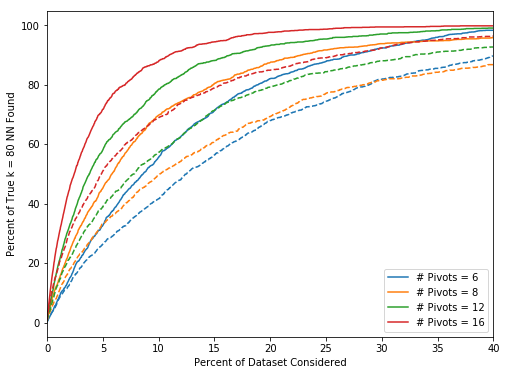

In [16]:
plt.figure(figsize=(8,6))

F1 = all_found1.mean(axis=1)
for i in range(F1.shape[0]):
    plt.plot(100*np.arange(n)/n, F1[i]/k*100, label='# Pivots = %s' % pivots[i])

plt.gca().set_prop_cycle(None)
F2 = all_found2.mean(axis=1)
for i in range(F2.shape[0]):
    plt.plot(100*np.arange(n)/n, F2[i]/k*100, '--')

# plt.axvline(5, linestyle='--', color='k')
plt.xlim([0, 40])
plt.xlabel('Percent of Dataset Considered')
plt.ylabel('Percent of True k = 80 NN Found')
plt.legend()

In [17]:
print(F1[:,k]/k * 100)
print(F2[:,k]/k * 100)

[14.8125 23.75   32.5    44.75  ]
[12.6875 17.6875 21.4375 30.25  ]


# todo
 - plot std for above plots
 - is edit distance really worse?
 - try lower dimension to more fully span the subspace
 - recall@k is given some true top-k, when algo returns best k, what fraction of the returned items are in the true top-k
 - for k = 1% of dataset, this seems worse than PQ => how many pivots do I need to get equivalent recall@k?
 - try manifold with neural network instead of subspace
 - 

In [42]:

data = {}
data['size'] = [i/n * 100 for i in range(800) for _ in range(trials)]
for i,p in enumerate(pivots):
    data[str(p)] = all_found1[i,:,:800].reshape((20*800), order='F')

df = pd.DataFrame(data)
print(df.head())

   size    6    8   12   16
0   0.0  0.0  0.0  0.0  1.0
1   0.0  0.0  0.0  0.0  1.0
2   0.0  0.0  0.0  1.0  0.0
3   0.0  0.0  1.0  1.0  1.0
4   0.0  1.0  0.0  0.0  1.0


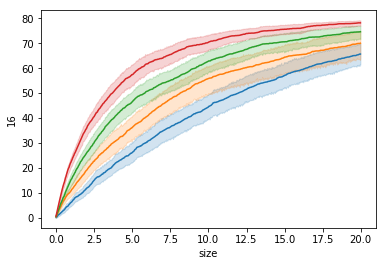

In [43]:
sns.lineplot('size', '6', data=df)
sns.lineplot('size', '8', data=df)
sns.lineplot('size', '12', data=df)
sns.lineplot('size', '16', data=df)

In [44]:
data = {}
data['size'] = [i/n * 100 for i in range(800) for _ in range(trials)]
for i,p in enumerate(pivots):
    data[str(p)] = all_found2[i,:,:800].reshape((20*800), order='F')

df2 = pd.DataFrame(data)
print(df2.head())

   size    6    8   12   16
0   0.0  1.0  1.0  0.0  1.0
1   0.0  0.0  0.0  0.0  1.0
2   0.0  0.0  0.0  1.0  1.0
3   0.0  0.0  1.0  1.0  1.0
4   0.0  0.0  0.0  1.0  1.0


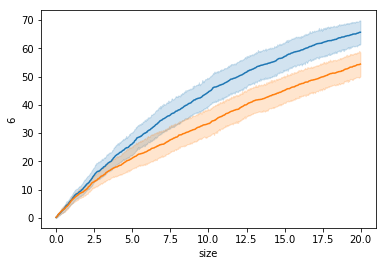

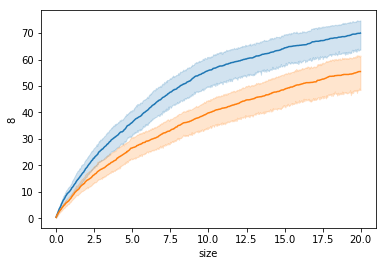

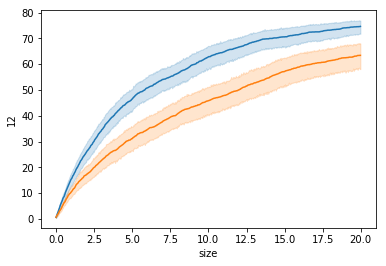

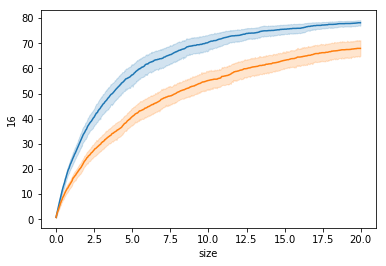

In [46]:
plt.figure()
sns.lineplot('size', '6', data=df)
sns.lineplot('size', '6', data=df2)

plt.figure()
sns.lineplot('size', '8', data=df)
sns.lineplot('size', '8', data=df2)

plt.figure()
sns.lineplot('size', '12', data=df)
sns.lineplot('size', '12', data=df2)

plt.figure()
sns.lineplot('size', '16', data=df)
sns.lineplot('size', '16', data=df2)

In [4]:
trials = 20
n = 4000
d = 8
D = 128
means = 0.5 + 0.09*np.random.randn(d)
Cov = 0.01*np.eye(d)
data_low = np.random.multivariate_normal(means, Cov, size=n)
L = (np.random.randn(d, D)+1)/d
data_high = data_low @ L # shape = (n, D)

queries = np.array([generate_query(means, Cov, L) for _ in range(trials)]) # shape = (trials, D)
sort_idxs = np.array([np.argsort([np.linalg.norm(u-query) for u in data_high]) for query in queries]) # shape = (trials, n)

pivots = piv = [6,8,12,16]
k = 80
all_found1 = np.zeros((len(pivots), trials, n))
# all_found2 = np.zeros((len(pivots), trials, n))
for t in range(trials):
    query = queries[t]
    found = np.zeros((len(piv), n))
    sort_idx = sort_idxs[t]
    for j, num_pivots in enumerate(pivots):
        anchor_idx = np.random.choice(n, size=num_pivots)
        anchors = np.array([data_high[i] for i in anchor_idx])
        perms1 = np.zeros((n, num_pivots))
#         perms2 = n*['0']
        for i in range(n):
            perm = np.argsort([np.linalg.norm(data_high[i]-a) for a in anchors])
            perms1[i] = perm
#             perms2[i] = ''.join([chr(c) for c in perm])

        dperm = distance_permutation(query, anchors)
#         dperm_str = ''.join([chr(c) for c in dperm])
        sort_perm_idx1 = np.argsort([np.linalg.norm(np.argsort(p)-np.argsort(dperm)) for p in perms1])
#         sort_perm_idx2 = np.argsort([edit_distance(dperm_str, p) for p in perms2])

        for c, idx1 in enumerate(sort_perm_idx1):
            if idx1 in sort_idx[:k]:
                all_found1[j,t,c] = all_found1[j,t,c-1] + 1
            else:
                all_found1[j,t,c] = all_found1[j,t,c-1]